# Imports

In [6]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
%matplotlib inline

from matplotlib.pylab import rcParams
rcParams['figure.figsize'] = 20,10
from keras.models import Sequential
from keras.layers import LSTM, Dropout, Dense

from sklearn.preprocessing import MinMaxScaler

# Read the dataset

In [7]:
df = pd.read_csv("Quote-Equity-TATAGLOBAL-EQ-15-02-2023-to-15-03-2023.csv")
df.head()

,Date,series,OPEN,HIGH,LOW,PREV. CLOSE,ltp,close,vwap,52W,52W L,VOLUME,VALUE,No of trades
0,15-Mar-2023,EQ,696.00,699.95,686.60,693.30,689.80,687.55,692.33,861.15,686.60,1119482,"775,046,475.10",49390
1,14-Mar-2023,EQ,696.00,700.00,689.45,694.15,693.95,693.30,694.88,861.15,689.45,1501579,"1,043,411,950.15",46084
2,13-Mar-2023,EQ,705.00,707.30,691.75,704.40,695.70,694.15,698.08,861.15,691.75,1158330,"808,612,415.75",49727
3,10-Mar-2023,EQ,707.00,710.20,701.35,709.25,705.10,704.40,705.77,861.15,650.20,970983,"685,291,589.70",34171
4,09-Mar-2023,EQ,722.85,722.85,708.10,720.50,710.75,709.25,714.41,861.15,650.20,905544,"646,926,105.05",27396


# Analyze the closing prices from dataframe

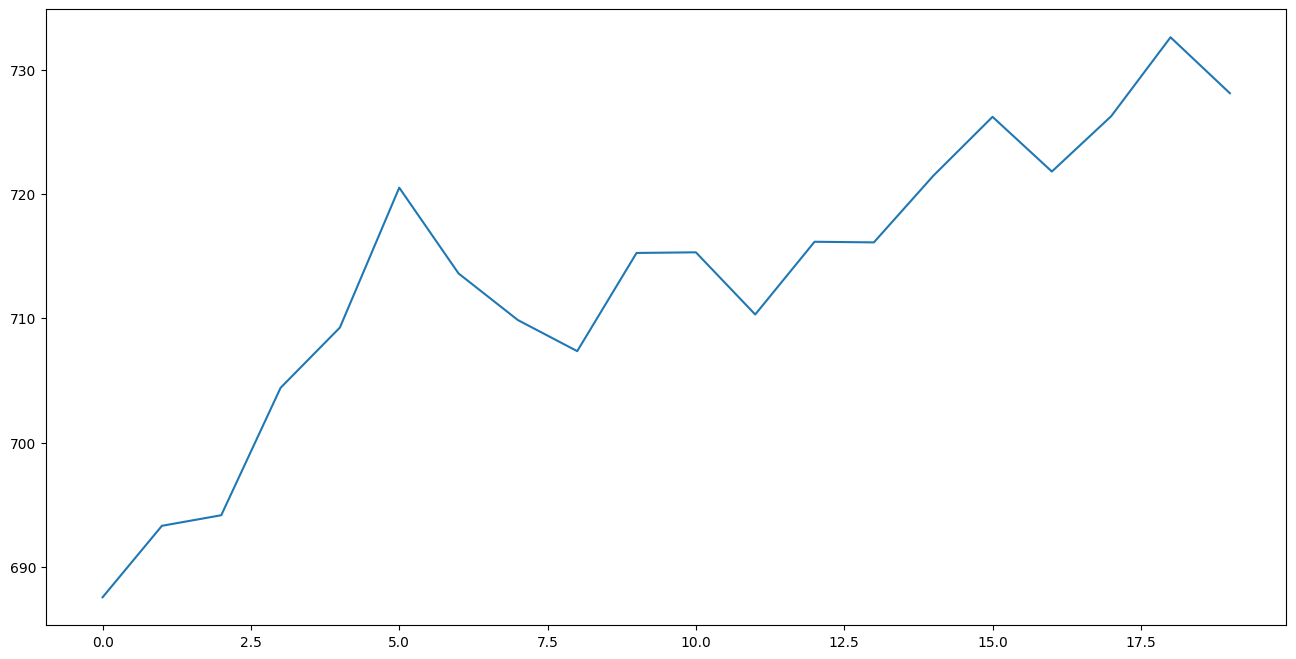

In [8]:
plt.figure(figsize=(16, 8))
plt.plot(df["close"], label = 'Close Price History')

# Sort the dataset on date time and filter “Date” and “Close” columns

In [9]:
data = df.sort_index(ascending=True, axis=0)
new_dataset = pd.DataFrame(index = range(0,len(df)),columns = ['Date', 'Close'])

for i in range(0, len(data)):
    new_dataset["Date"][i] = data['Date']
    new_dataset["close"][i] = data["close"][i]

# Normalize the new filtered dataset

In [10]:
scaler=MinMaxScaler(feature_range=(0,1))
final_dataset=new_dataset.values
train_data=final_dataset[0:987,:]
valid_data=final_dataset[987:,:]
new_dataset.index=new_dataset.Date
new_dataset.drop("Date",axis=1,inplace=True)
scaler=MinMaxScaler(feature_range=(0,1))
scaled_data=scaler.fit_transform(final_dataset)
x_train_data,y_train_data=[],[]
for i in range(60,len(train_data)):
    x_train_data.append(scaled_data[i-60:i,0])
    y_train_data.append(scaled_data[i,0])
    
x_train_data,y_train_data=np.array(x_train_data),np.array(y_train_data)
x_train_data=np.reshape(x_train_data,(x_train_data.shape[0],x_train_data.shape[1],1))

#  Build and train the LSTM model

In [12]:
lstm_model=Sequential()
lstm_model.add(LSTM(units=50,return_sequences=True,input_shape=(x_train_data.shape[1],1)))
lstm_model.add(LSTM(units=50))
lstm_model.add(Dense(1))
inputs_data=new_dataset[len(new_dataset)-len(valid_data)-60:].values
inputs_data=inputs_data.reshape(-1,1)
inputs_data=scaler.transform(inputs_data)
lstm_model.compile(loss='mean_squared_error',optimizer='adam')
lstm_model.fit(x_train_data,y_train_data,epochs=1,batch_size=1,verbose=2)

# Take a sample of a dataset to make stock price predictions using the LSTM model

In [14]:
X_test=[]
for i in range(60,inputs_data.shape[0]):
    X_test.append(inputs_data[i-60:i,0])
X_test=np.array(X_test)
X_test=np.reshape(X_test,(X_test.shape[0],X_test.shape[1],1))
predicted_closing_price=lstm_model.predict(X_test)
predicted_closing_price=scaler.inverse_transform(predicted_closing_price)